<img style="width:100%" src="https://thumbs.dreamstime.com/t/banner-shoulder-ray-blue-tone-part-rib-130883110.jpg"><br><br>
# X-Ray Classifier
<br>

## Pneumonia detection

In [1]:
#!python -m pip install --upgrade pip
#!pip install scikit-learn==1.2
#!pip install imblearn

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm # Progress bar
import cv2
from glob import glob

# To resize images
import sklearn
import skimage
from skimage.transform import resize

import random
# We will use datetime to name files
import datetime

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from skimage.color import rgb2gray

print(tf.__version__)


C:\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


2.14.0


In [20]:
# To load internet images we will use these libraries.
from PIL import Image
import requests
from io import BytesIO

In [3]:
train_dir = "chest_xray/train/"
test_dir =  "chest_xray/test/"

LOAD_FROM_IMAGES = False

def get_data(folder):
    X = []
    y = []
    # Foreach folder...
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
            # Foreach image in this folder...
            # tqdm method is really good with for iterations.
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    # Resizing the image
                    img_file = skimage.transform.resize(img_file, (150, 150, 3),mode='constant',anti_aliasing=True)
                    # Turn the image into B/W so you only have to analyze 1 layer.
                    img_file = rgb2gray(img_file)
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    # Numpy image array.
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

# Since this process is really tedious and laborious, we're going to configure this to save the recorded arrays.
if LOAD_FROM_IMAGES:
    # We load the images to the arrays
    X_train, y_train = get_data(train_dir)
    X_test, y_test= get_data(test_dir)
    
    # We save the arrays to files
    np.save('xtrain.npy', X_train)
    np.save('ytrain.npy', y_train)
    np.save('xtest.npy', X_test)
    np.save('ytest.npy', y_test)
else:
    # We load the previously recorded arrays
    X_train = np.load('xtrain.npy')
    y_train = np.load('ytrain.npy')
    X_test = np.load('xtest.npy')
    y_test = np.load('ytest.npy')


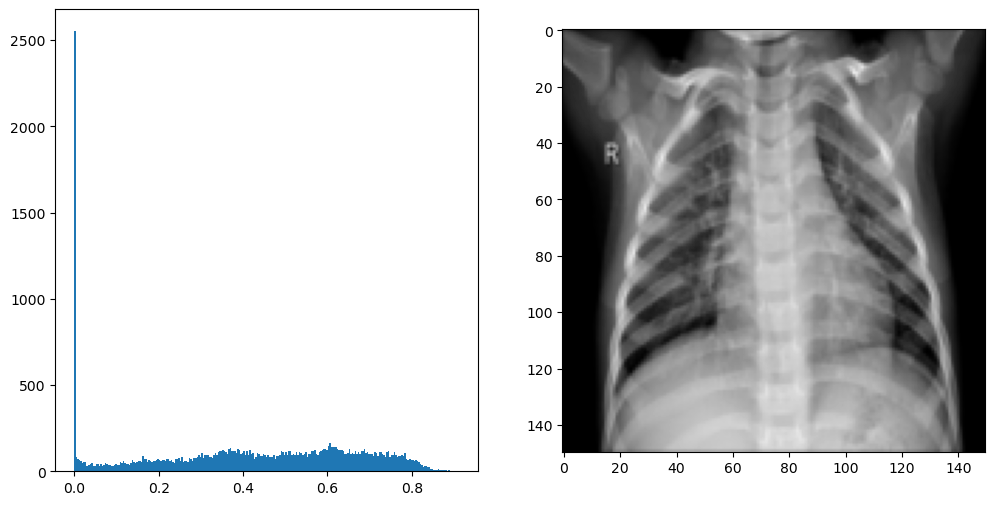

In [4]:
def plotHistogram(a):
    plt.figure(figsize=(12,6))
    plt.subplot(1, 2, 1)
    plt.hist(a.ravel(), bins=255)
    plt.subplot(1, 2, 2)
    plt.imshow(a, cmap='gray', vmin=0, vmax=1)
    plt.show()
    
plotHistogram(X_train[4])

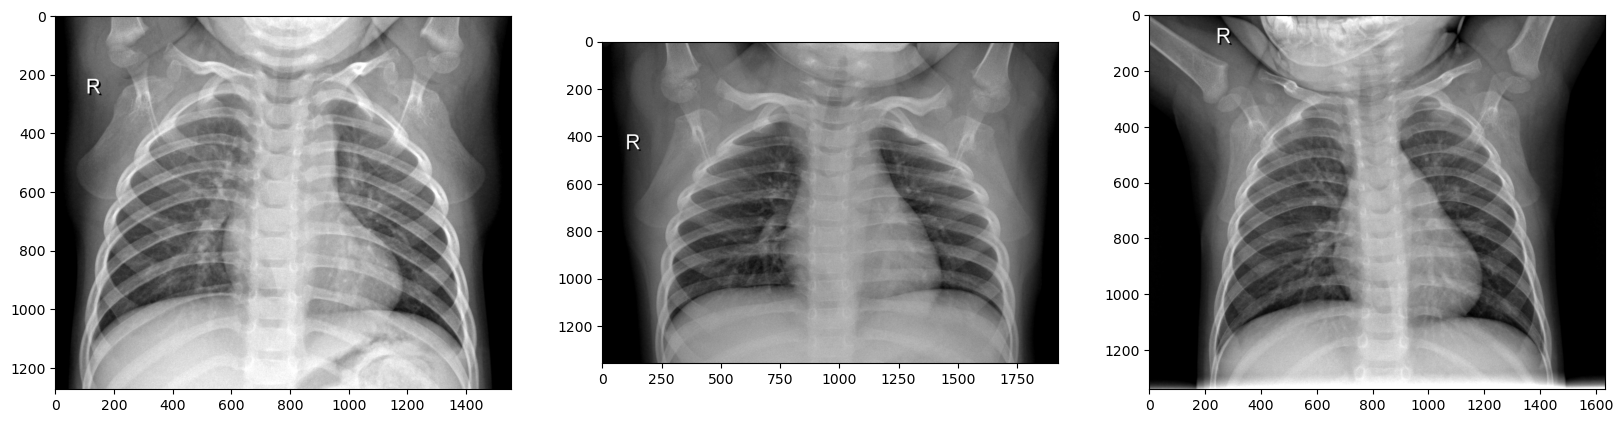

In [5]:
multipleImages = glob('chest_xray/train/NORMAL/**')

def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
    
plotThreeImages(multipleImages)

Without Pneumonia


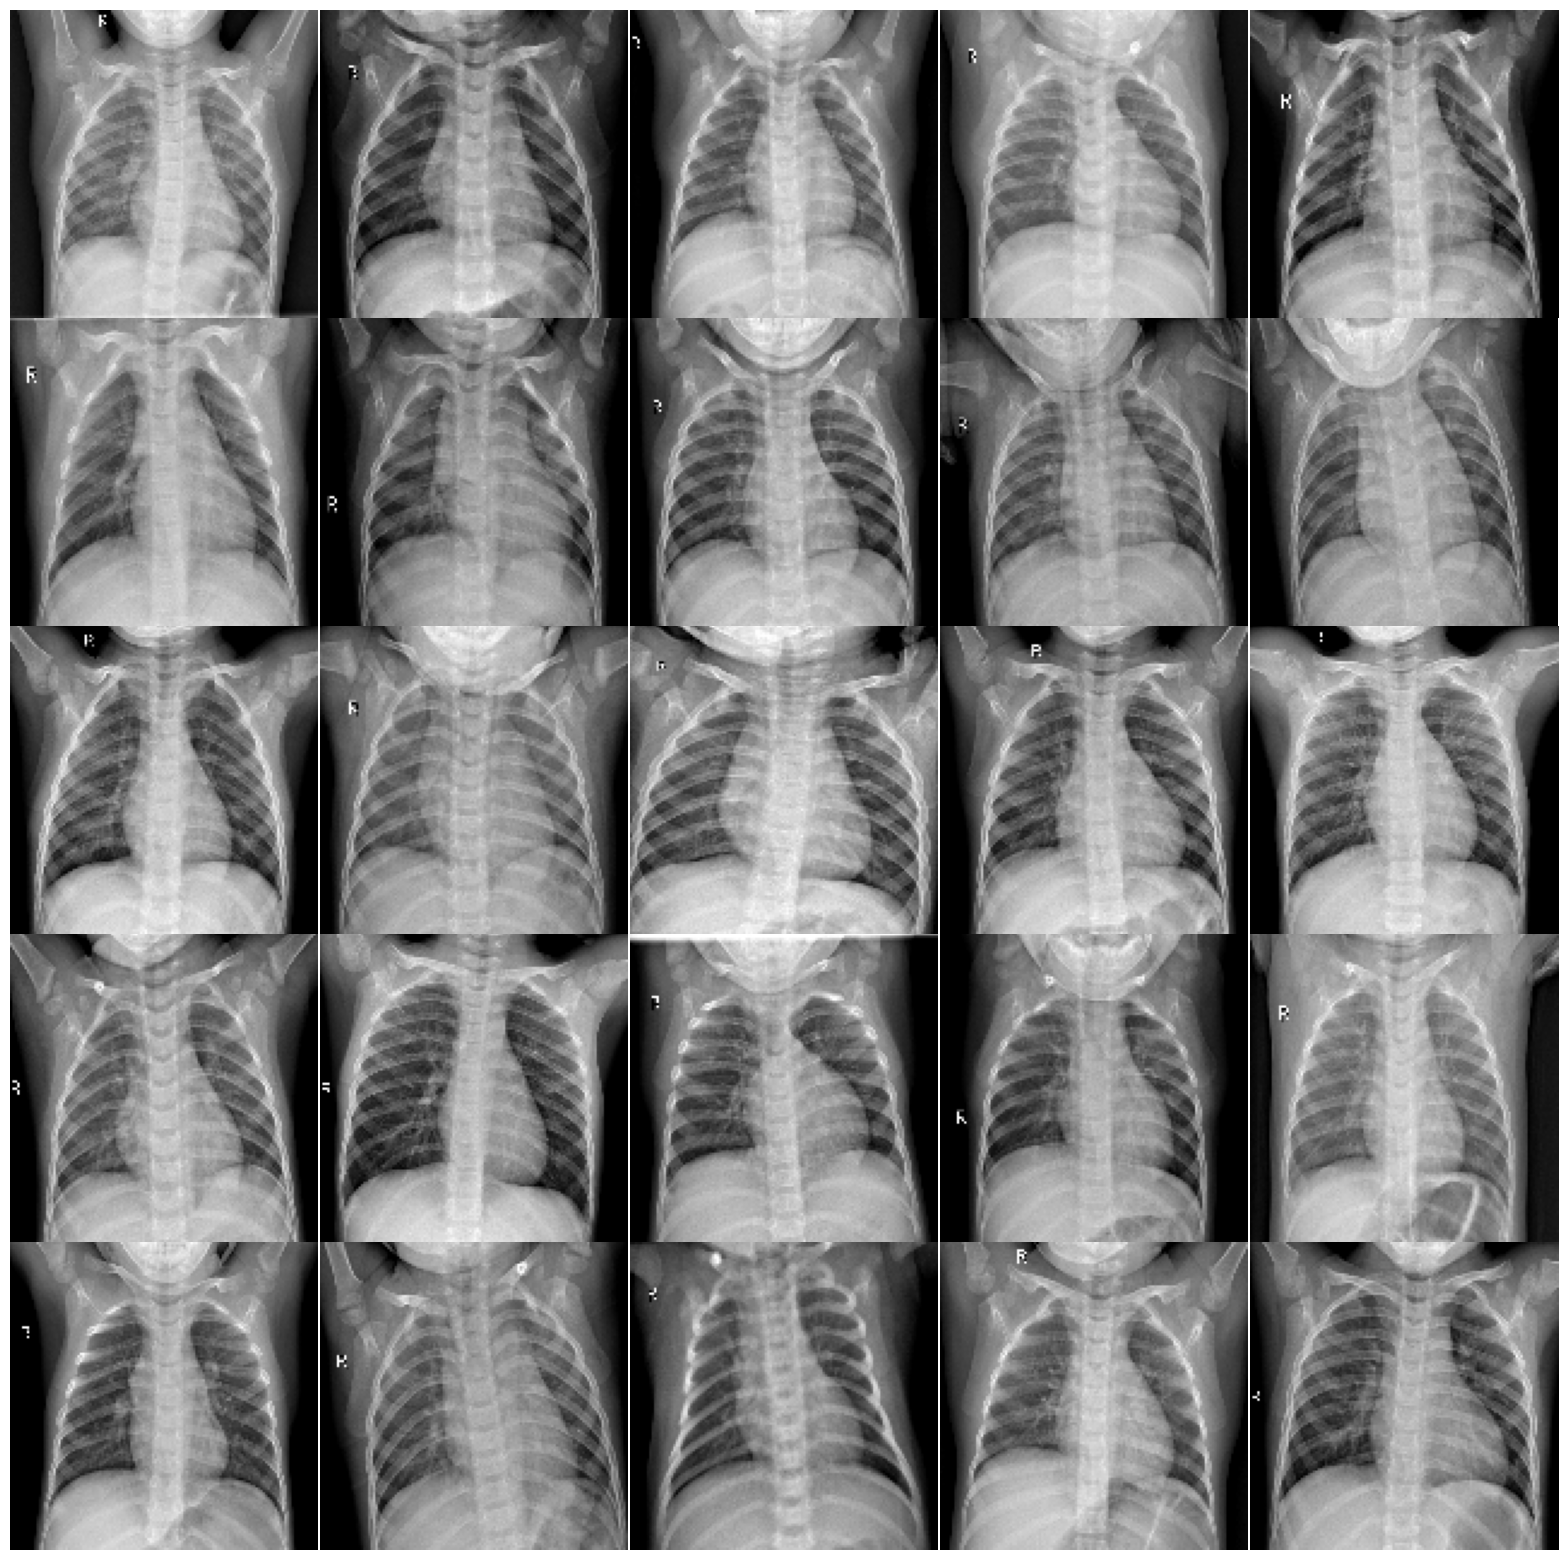

In [6]:
print("Without Pneumonia")
multipleImages = glob('chest_xray/train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.subplots_adjust(wspace=0, hspace=0)

for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) 
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

WITH Pneumonia


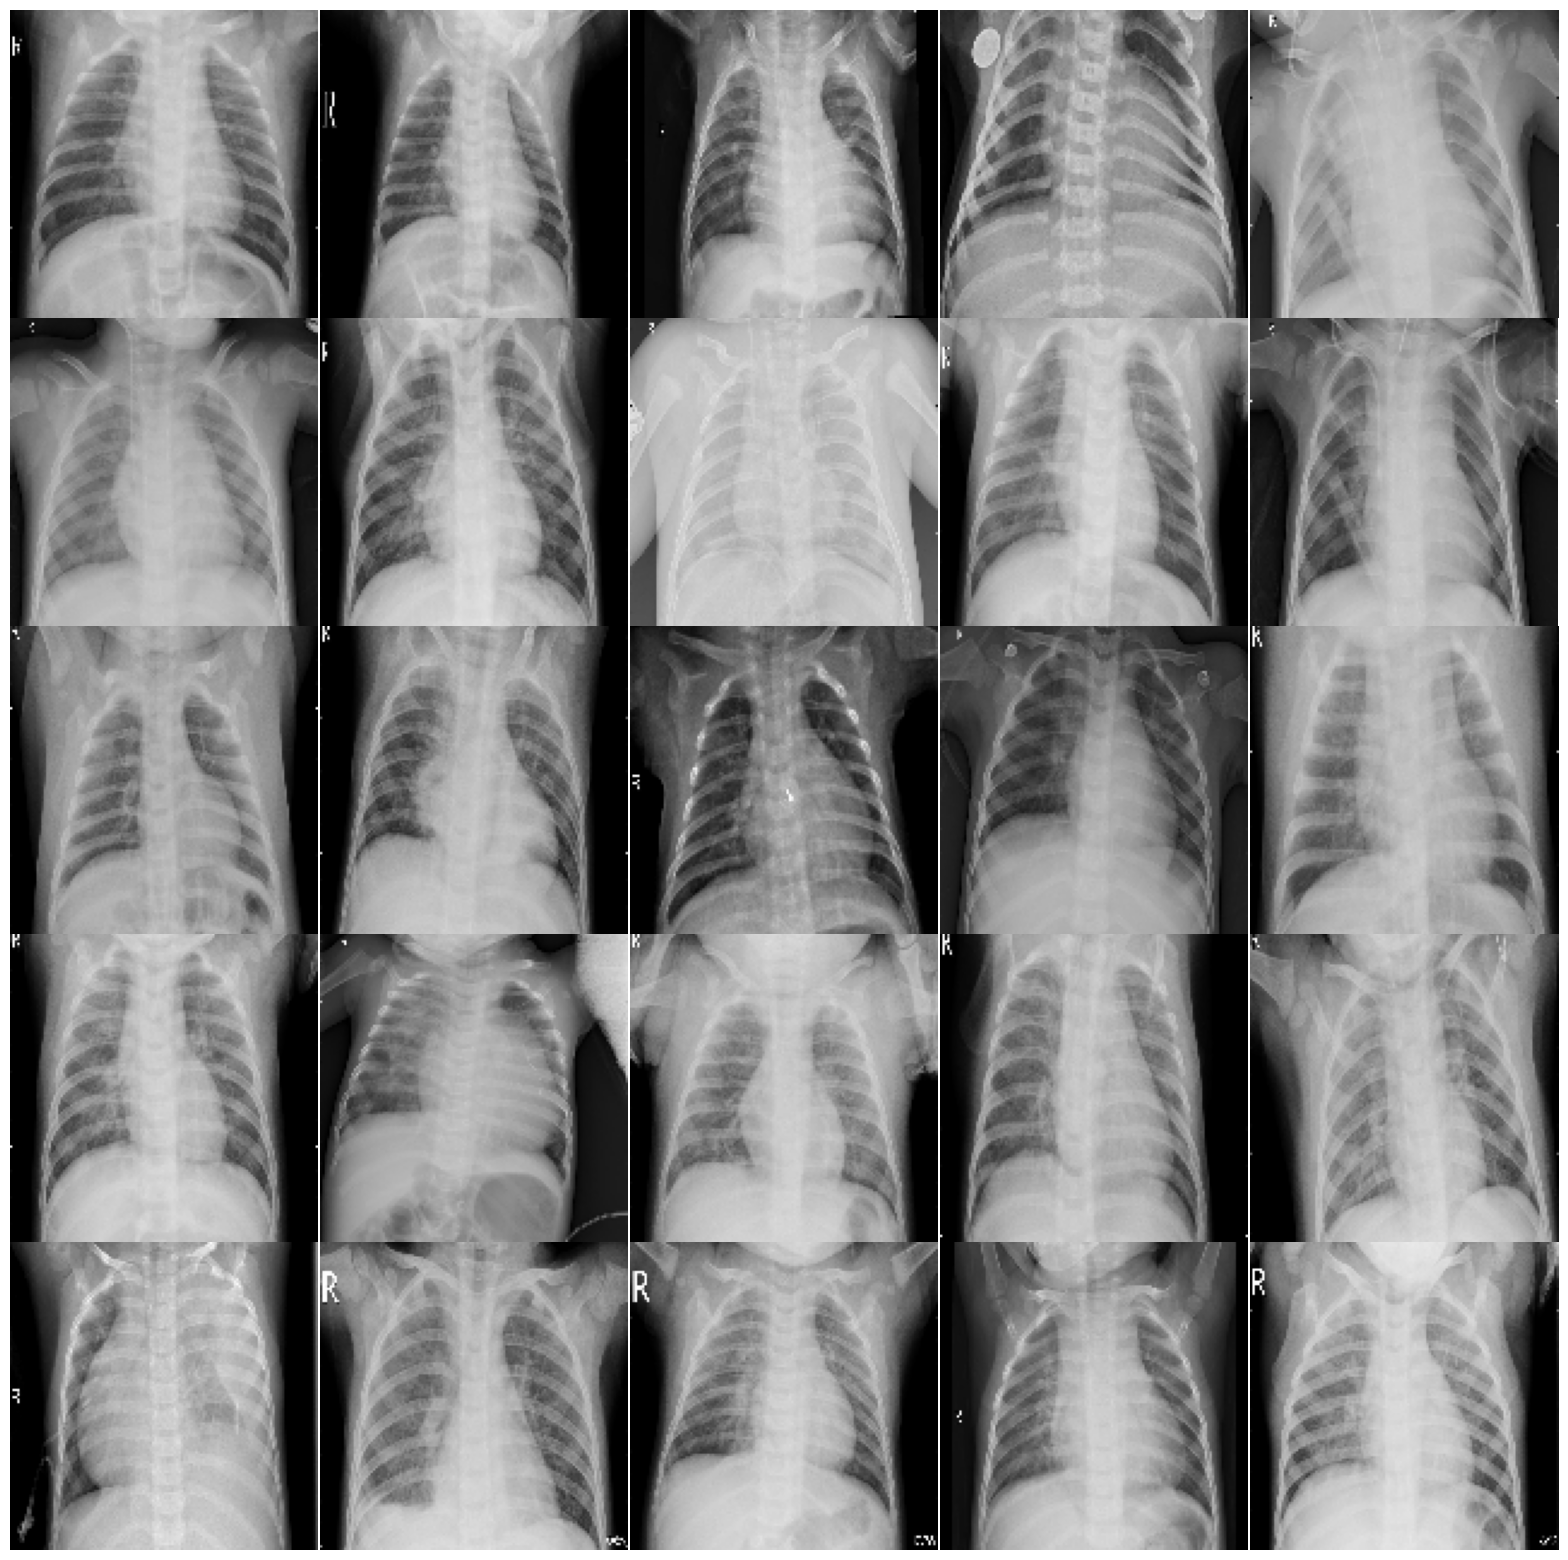

In [7]:
print("WITH Pneumonia")
multipleImages = glob('chest_xray/train/PNEUMONIA/**')
i_ = 0
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

{0: 'WITH Pneumonia', 1: 'Without Pneumonia'}


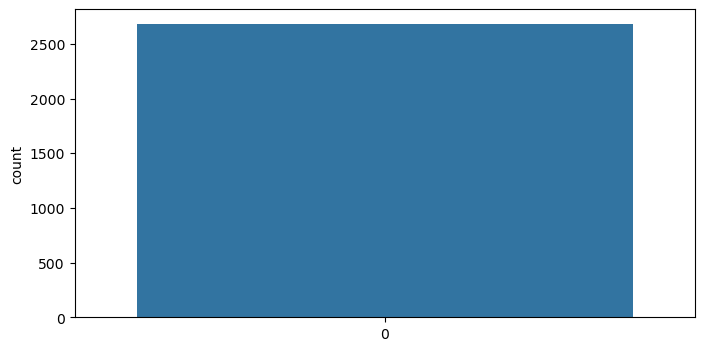

In [8]:
import seaborn as sns

plt.figure(figsize=(8,4))
map_characters = {0: 'WITH Pneumonia', 1: 'Without Pneumonia'}
dict_characters=map_characters

df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [11]:
X_train.shape

(2682, 150, 150)

In [10]:
X_trainReshaped = X_train.reshape(len(X_train),150,150,1)
X_testReshaped = X_test.reshape(len(X_test),150,150,1)

In [14]:
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [15]:
# 1 pneumonia, 0 normal.
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [16]:
# Compiling model.
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Directory to save Tensorboard logs.
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)

# Train the model.
model.fit(X_trainReshaped, 
          y_train, 
          epochs=20,
          validation_data = (X_testReshaped,y_test),
          callbacks=[tensorboard_callback])

Epoch 1/20
84/84 [==============================] - 102s 1s/step - loss: 0.4701 - accuracy: 0.7345 - val_loss: 0.4519 - val_accuracy: 0.7917
Epoch 2/20
84/84 [==============================] - 92s 1s/step - loss: 0.1821 - accuracy: 0.9292 - val_loss: 0.5387 - val_accuracy: 0.8013
Epoch 3/20
84/84 [==============================] - 92s 1s/step - loss: 0.1263 - accuracy: 0.9560 - val_loss: 0.6968 - val_accuracy: 0.7740
Epoch 4/20
84/84 [==============================] - 96s 1s/step - loss: 0.1086 - accuracy: 0.9553 - val_loss: 0.4266 - val_accuracy: 0.8429
Epoch 5/20
84/84 [==============================] - 96s 1s/step - loss: 0.0736 - accuracy: 0.9724 - val_loss: 0.8426 - val_accuracy: 0.7901
Epoch 6/20
84/84 [==============================] - 88s 1s/step - loss: 0.0547 - accuracy: 0.9761 - val_loss: 0.7373 - val_accuracy: 0.8093
Epoch 7/20
84/84 [==============================] - 90s 1s/step - loss: 0.0508 - accuracy: 0.9787 - val_loss: 0.7832 - val_accuracy: 0.8029
Epoch 8/20
84/84 [=

In [17]:
test_loss, test_acc = model.evaluate(X_testReshaped, y_test)
print(test_acc)

20/20 [==============================] - 4s 217ms/step - loss: 1.7974 - accuracy: 0.8045
0.8044871687889099


In [18]:
test_loss, test_acc = model.evaluate(X_trainReshaped, y_train)

84/84 [==============================] - 19s 226ms/step - loss: 0.0013 - accuracy: 0.9996


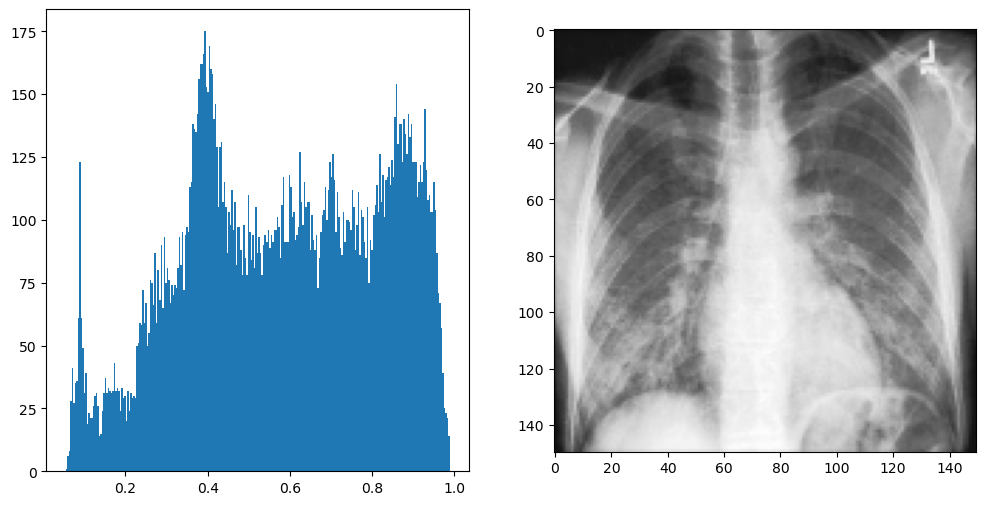

In [37]:
img_file = cv2.imread(".test_images/Pneumocystis_pneumonia_high_es.jpg")
if img_file is not None:
    # Resizing the image
    img_file = skimage.transform.resize(img_file, (150, 150, 3),mode='constant',anti_aliasing=True)
    # Turn the image into B/W so you only have to analyze 1 layer.
    img_file = rgb2gray(img_file)
plotHistogram(img_file)

In [40]:
img_file.shape

(150, 150)

In [41]:
x = np.zeros((1,150,150))

In [42]:
x[0] = np.array(img_file)

In [43]:
predictions = model.predict(x)
predictions[0]

1/1 [==============================] - 0s 114ms/step


array([7.061098e-09, 1.000000e+00], dtype=float32)

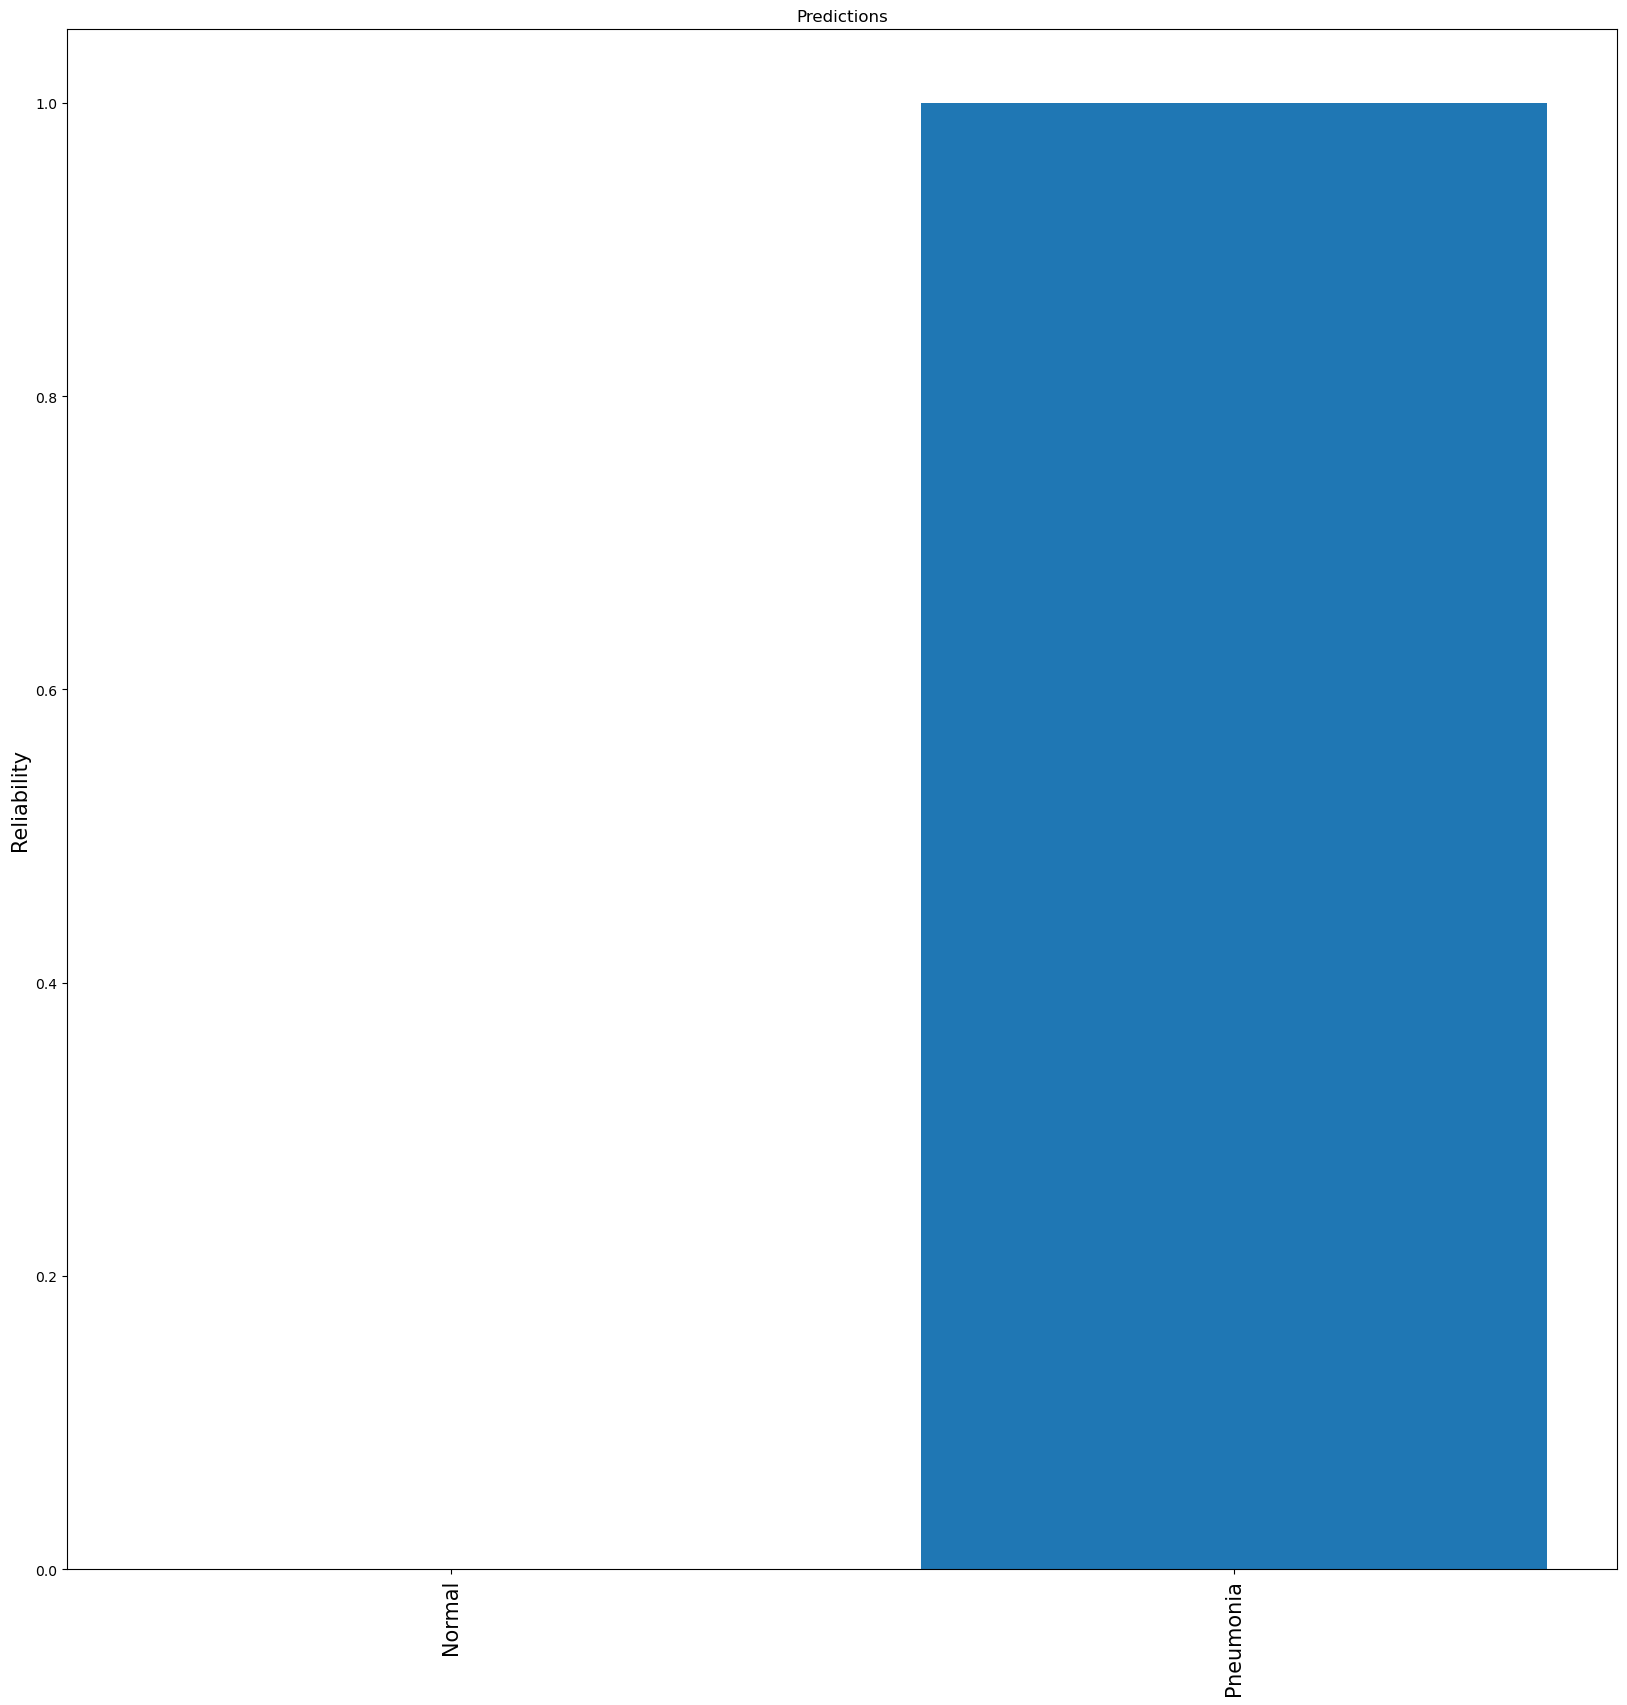

In [46]:
class_names = ['Normal', 'Pneumonia']
index = np.arange(len(class_names))
plt.bar(index, predictions[0])
plt.ylabel('Reliability', fontsize=15)
plt.xticks(index, class_names, fontsize=15, rotation=90)
plt.title('Predictions')
plt.show()